In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
splits = ['train[:70%]', 'train[70%:]']
(train_set, val_set), metadata = tfds.load('tf_flowers', with_info=True, split=splits, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
num_train = 0
num_val = 0

for example in train_set:
  num_train += 1

for example in val_set:
  num_val += 1

In [5]:
num_classes = metadata.features['label'].num_classes

In [6]:
print(num_train)
print(num_val)
print(num_classes)

2569
1101
5


In [48]:
for i, example in enumerate(train_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [7]:
IMAGE_RES = 224;
BATCH_SIZE = 32;

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

train_batches = train_set.shuffle(num_train).map(format_image).batch(BATCH_SIZE).prefetch(1)
val_batches = val_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [49]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, trainable=False)

In [50]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(5 , activation='softmax')
])

In [53]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches)

Epoch 1/6
81/81 [==============================] - 121s 1s/step - loss: 0.8163 - accuracy: 0.6937 - val_loss: 0.4547 - val_accuracy: 0.8447
Epoch 2/6
81/81 [==============================] - 97s 1s/step - loss: 0.3862 - accuracy: 0.8715 - val_loss: 0.3558 - val_accuracy: 0.8819
Epoch 3/6
81/81 [==============================] - 136s 2s/step - loss: 0.3021 - accuracy: 0.9046 - val_loss: 0.3257 - val_accuracy: 0.8847
Epoch 4/6
81/81 [==============================] - 119s 1s/step - loss: 0.2539 - accuracy: 0.9253 - val_loss: 0.3246 - val_accuracy: 0.8919
Epoch 5/6
81/81 [==============================] - 126s 2s/step - loss: 0.2200 - accuracy: 0.9377 - val_loss: 0.3034 - val_accuracy: 0.8919
Epoch 6/6
81/81 [==============================] - 121s 1s/step - loss: 0.1925 - accuracy: 0.9494 - val_loss: 0.2854 - val_accuracy: 0.9083


In [54]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Loss')

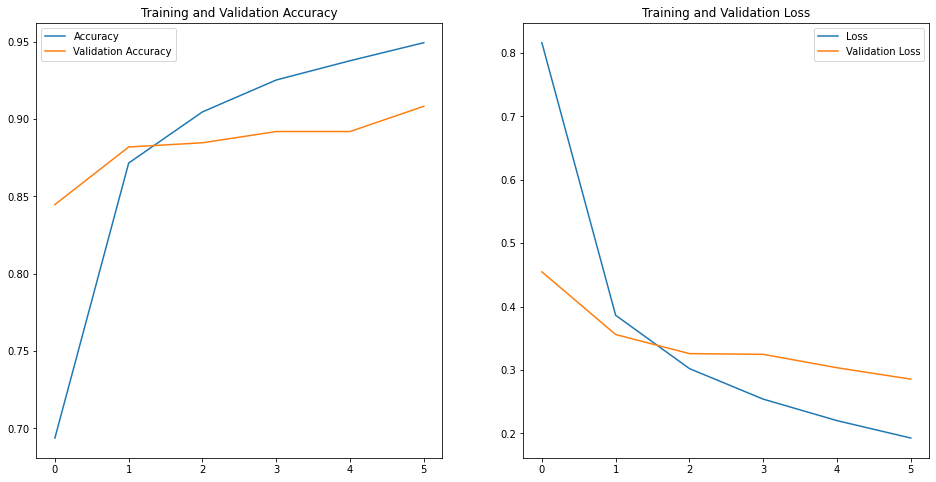

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [64]:
class_names = np.array(metadata.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [68]:
predicted_batch.argmax(axis=-1)

array([2, 2, 2, 0, 4, 4, 1, 1, 2, 1, 3, 3, 0, 3, 3, 2, 0, 2, 4, 2, 2, 1,
       0, 0, 3, 1, 0, 2, 0, 2, 3, 2])

In [70]:
image_batch, label_batch = next(iter(train_batches))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = predicted_batch.argmax(axis=-1)
predicted_labels = class_names[predicted_ids]


1/1 [==============================] - 1s 824ms/step


In [72]:
print(label_batch)
print(predicted_ids)

tf.Tensor([0 0 2 0 2 3 0 4 3 2 0 2 0 3 1 0 0 0 0 4 0 0 3 0 2 0 2 2 4 4 1 1], shape=(32,), dtype=int64)
[0 0 2 0 2 3 0 4 3 2 0 2 0 3 0 0 0 0 0 4 0 0 3 0 2 0 2 2 4 4 1 1]


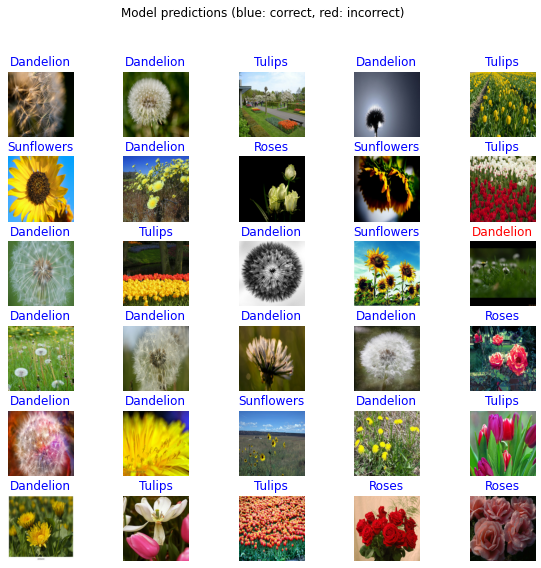

In [73]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [10]:
URL2 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor2 = hub.KerasLayer(URL2, trainable=False)

In [8]:
IMAGE_RES = 299;
BATCH_SIZE = 32;

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

train_batches = train_set.shuffle(num_train).map(format_image).batch(BATCH_SIZE).prefetch(1)
val_batches = val_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
model2 = tf.keras.Sequential([
    feature_extractor2,
    tf.keras.layers.Dense(5 , activation='softmax')
])

In [12]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 6
history2 = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches)

Epoch 1/6
81/81 [==============================] - 33s 219ms/step - loss: 0.7644 - accuracy: 0.7287 - val_loss: 0.4752 - val_accuracy: 0.8374
Epoch 2/6
81/81 [==============================] - 14s 174ms/step - loss: 0.4107 - accuracy: 0.8669 - val_loss: 0.3719 - val_accuracy: 0.8692
Epoch 3/6
81/81 [==============================] - 14s 175ms/step - loss: 0.3192 - accuracy: 0.8996 - val_loss: 0.3351 - val_accuracy: 0.8856
Epoch 4/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2754 - accuracy: 0.9132 - val_loss: 0.3230 - val_accuracy: 0.8765
Epoch 5/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2412 - accuracy: 0.9264 - val_loss: 0.2882 - val_accuracy: 0.9010
Epoch 6/6
81/81 [==============================] - 14s 176ms/step - loss: 0.2157 - accuracy: 0.9354 - val_loss: 0.2909 - val_accuracy: 0.9010


In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Loss')

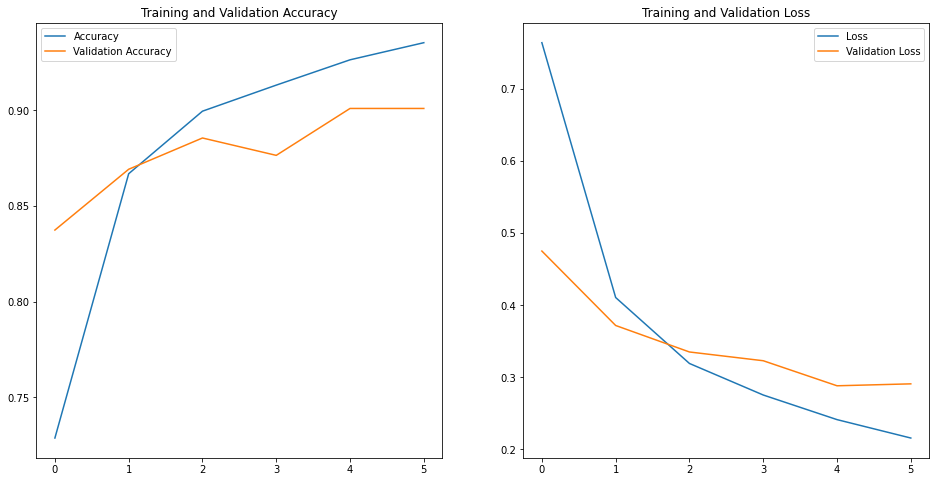

In [15]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')